# Statistical analysis comparing PEA software test set and flight data

Ref: https://chandramission.slack.com/archives/C01D83RUG0L/p1724092824832339


Mag_<0-7>_sim_info    Actual AGASC Star Magnitude
ccd_temp              CCD Temperature (degC)
search_success_<0-7>  Acquisition success (0 or 1)
search_box_hw_<n>     Search box size (arc-sec, half width)

% Search success is:
%    image_fcn is 1 (TRAK) and 
%    image_row+4 is within 2 px of the star_row and 
%    image_col+4 within 2 px of the star_col


In [1]:
import sys

sys.path.insert(0, "/Users/aldcroft/git/chandra_aca")

import numpy as np
from pathlib import Path
import os
from collections import Counter
import itertools

from scipy.stats import binom
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.style
from matplotlib import patches
import tables
from cxotime import CxoTime
import agasc

from utils_asvt import flatten_pea_test_data, read_twiki_csv

matplotlib.style.use("bmh")
%matplotlib inline

In [2]:
def get_vals_and_bins(vals):
    out_vals = np.array(sorted(set(vals)))
    out_val_centers = (out_vals[1:] + out_vals[:-1]) / 2
    out_val_bins = np.concatenate(
        [
            [out_vals[0] - (out_vals[1] - out_vals[0]) / 2],
            out_val_centers,
            [out_vals[-1] + (out_vals[-1] - out_vals[-2]) / 2],
        ]
    )
    return out_vals, out_val_bins

In [3]:
t_ccd_vals, t_ccd_bins = get_vals_and_bins([-13, -11, -9, -7, -5, -3])
mag_vals, mag_bins = get_vals_and_bins([8.5, 9, 9.5, 10, 10.5])
zeros = np.zeros(shape=(len(mag_vals), len(t_ccd_vals)), dtype=int)


In [4]:
def as_table(arr, fmt=None):
    """Turn one of the summary 6x6 arrays into a readable table"""
    t = Table()
    t["mag"] = [str(val) for val in mag_vals]
    names = [f"{t_ccd:.1f}" for t_ccd in t_ccd_vals]
    for jj, name in enumerate(names):
        t[name] = arr[:, jj]
        if fmt:
            t[name].info.format = fmt
    return t


In [5]:
def get_sampling(dat):
    # Aggregate binned number of samples and successes for ASVT data
    n_samp = zeros.copy()
    n_succ = zeros.copy()
    # Bin halfwidths (narrow since ASVT data are all at the same mag, T_ccd)
    for ii, mag0, mag1 in zip(itertools.count(), mag_bins[:-1], mag_bins[1:]):
        for jj, t_ccd0, t_ccd1 in zip(
            itertools.count(), t_ccd_bins[:-1], t_ccd_bins[1:]
        ):
            ok0 = (dat["star_mag"] >= mag0) & (dat["star_mag"] < mag1)
            ok1 = (dat["ccd_temp"] >= t_ccd0) & (dat["ccd_temp"] < t_ccd1)
            ok = ok0 & ok1
            n_samp[ii, jj] = np.count_nonzero(ok)
            n_succ[ii, jj] = np.count_nonzero(dat["search_success"][ok])
    return n_samp, n_succ

In [6]:
SKA = Path(os.environ["SKA"])

In [7]:
swats8 = Table.read(
    "../PEA_SW_TS_Acq_results_2024_08_27_w_more flight_like_maxmag.csv",
    format="ascii.csv",
)

In [8]:
swats = flatten_pea_test_data(swats8)
swats.rename_column("Mag_sim_info", "star_mag")
# Some bright stars around 1.0 mag
swats = swats[swats["star_mag"] > 4.0]

In [9]:
len(swats), len(swats8)

(68997, 8628)

In [10]:
for halfw in (60, 80, 100, 120, 140, 160):
    dat = swats[swats["search_box_hw"] == halfw]
    n_samp, n_succ = get_sampling(dat)
    print(f"Halfwidth {halfw}:")
    print(as_table(n_samp))
    print()

Halfwidth 60:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ----
 8.5     0     1    1    4    2    4
 9.0     3     1    5    8    6    8
 9.5     0     4   33  133   45  133
10.0    13    78  178  245  234  246
10.5    17    61   88  236  183  240

Halfwidth 80:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ----
 8.5     1     2   15   80   27   80
 9.0    13    71  252  313  270  313
 9.5    21    96  202  208  219  208
10.0    10    14   22   47   42   48
10.5     2    17   81  183  124  184

Halfwidth 100:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ----
 8.5    16    46  134  113  140  113
 9.0    19    41   82   79   94   79
 9.5     8    43   83   95  101   95
10.0     3    23   50  108   84  110
10.5     2    42   95  199  131  199

Halfwidth 120:
mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ----
 8.5     1     2    4    9    8    9
 9.0     1     0    8   26   21   26
 9.5     1    

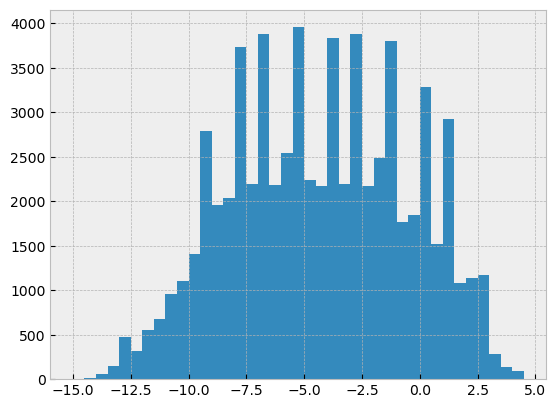

In [11]:
plt.hist(swats["ccd_temp"], bins=np.arange(-15, 5, 0.5));

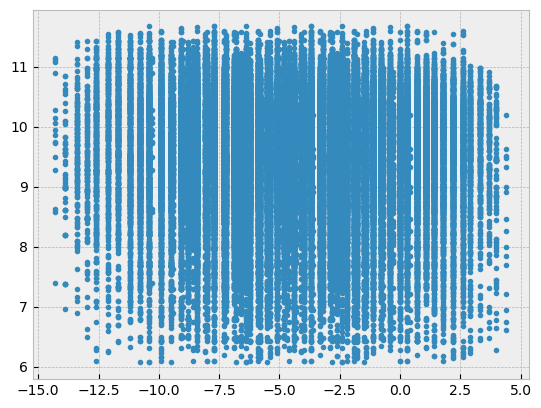

In [12]:
plt.plot(swats["ccd_temp"], swats["star_mag"], ".");

In [13]:
", ".join(sorted(swats.colnames))

'Acq_Complete, BG_Col_Offset, BG_Row_Offset, CC_Flag, CMDS, CalTemp_one_256th_degC, Centroid_Col_px, Centroid_Row_px, Cmd_Count, Cmd_Group_Cksum_Fail_flag, Corner_Col_px, Corner_Row_px, DP_Flag, Est_Flight_Q1, Est_Flight_Q2, Est_Flight_Q3, Est_Flight_Q4, High_Bg_flag, ID_str, IR_flag, Img_Fcn, Int_Cycle, Int_Time, Int_Time_16ms, MS_Flag, Mag_Limit, Mag_acq_data_table, Mag_scaled, Max_Num_Search_Hits, Num_Search_Hits, ObsID, PX_FILE, Proc_Reset_flag, QB_Flag, Rand_Ind, Rec_Num, Rows_to_Go, SP_Flag, Search_Box_Col_Offset, Search_Box_Row_Offset, Star_Col, Star_Row, Syntax_Err_flag, TITLE, Yang, Yang_scaled, Zang, Zang_scaled, ccd_temp, int_time, num_slots, search_box_hw, search_success, slot, star_mag'

In [41]:
HALFWIDTH = 160  # Do analysis for one search box size

In [42]:
dat = swats[swats["search_box_hw"] == HALFWIDTH]
len(dat)

47958

In [43]:
set(dat["search_box_hw"])

{160}

In [44]:
n_samp_asvt, n_succ_asvt = get_sampling(dat)

In [45]:
acq_file = SKA / "data" / "acq_stats" / "acq_stats.h5"
with tables.open_file(acq_file, "r") as h5:
    cols = h5.root.data.cols
    names = {
        "tstart": "guide_tstart",
        "obsid": "obsid",
        "obc_id": "acqid",
        "halfwidth": "halfw",
        "mag_aca": "mag_aca",
        "mag_obs": "mag_obs",
        "known_bad": "known_bad",
        "color": "color1",
        "img_func": "img_func",
        "ion_rad": "ion_rad",
        "sat_pix": "sat_pix",
        "agasc_id": "agasc_id",
        "t_ccd": "ccd_temp",
        "slot": "slot",
    }
    acqs = Table(
        [getattr(cols, h5_name)[:] for h5_name in names.values()],
        names=list(names.keys()),
    )


In [46]:
# Only data since July 1, 2019 and for color != 1.5 stars. Also ignore any
# failures of IR or SP flags because those don't get generated in ASVT data.
ok0 = acqs["tstart"] > CxoTime("2019-07-01").secs
ok1 = ~np.isclose(acqs["color"], 1.5)
ok2 = ~acqs["ion_rad"] & ~acqs["sat_pix"]  #  & (acqs['halfwidth'] == HALFWIDTH)
flt = acqs[ok0 & ok2]
flt["ccd_temp"] = flt["t_ccd"]

In [47]:
np.count_nonzero(ok0), np.count_nonzero(ok0 & ~ok1), np.count_nonzero(~ok2), len(flt)

(87004, 8291, 1059, 86384)

In [48]:
len(flt)

86384

In [49]:
stars = agasc.get_stars(flt["agasc_id"], agasc_file="agasc*")
flt["star_mag"] = stars["MAG_ACA"]
flt["mag_catid"] = stars["MAG_CATID"]

In [50]:
np.count_nonzero(np.isclose(stars["COLOR1"], 1.5))

1

In [51]:
np.count_nonzero(flt["mag_catid"] == 100)

73318

In [52]:
bad_stars = agasc.get_supplement_table("bad")
len(bad_stars)

574

In [53]:
bad = np.isin(flt["agasc_id"], bad_stars["agasc_id"])
print(np.count_nonzero(bad))
flt = flt[~bad]

29


In [54]:
print(t_ccd_bins)
print(t_ccd_vals)

[-14. -12. -10.  -8.  -6.  -4.  -2.]
[-13 -11  -9  -7  -5  -3]


In [55]:
print(mag_bins)
print(mag_vals)

[ 8.25  8.75  9.25  9.75 10.25 10.75]
[ 8.5  9.   9.5 10.  10.5]


In [56]:
# Aggregate binned number of samples and successes for ASVT data

# Bin halfwidths (narrow since ASVT data are all at the same mag, T_ccd)
for ii, mag0, mag1 in zip(itertools.count(), mag_bins[:-1], mag_bins[1:]):
    for jj, t_ccd0, t_ccd1 in zip(itertools.count(), t_ccd_bins[:-1], t_ccd_bins[1:]):
        ok0 = (dat["star_mag"] >= mag0) & (dat["star_mag"] < mag1)
        ok1 = (dat["ccd_temp"] >= t_ccd0) & (dat["ccd_temp"] < t_ccd1)
        ok = ok0 & ok1
        n_samp_asvt[ii, jj] = np.count_nonzero(ok)
        n_succ_asvt[ii, jj] = np.count_nonzero(dat["search_success"][ok])


In [57]:
# # Aggregate binned number of samples and successes for Flight data

# # Bin halfwidths (narrow since ASVT data are all at the same mag, T_ccd)
# for ii, mag0, mag1 in zip(itertools.count(), mag_bins[:-1], mag_bins[1:]):
#     for jj, t_ccd0, t_ccd1 in zip(itertools.count(), t_ccd_bins[:-1], t_ccd_bins[1:]):
#         ok0 = (flt['star_mag'] >= mag0) & (flt['star_mag'] < mag1)
#         ok1 = (flt['ccd_temp'] >= t_ccd0) & (flt['ccd_temp'] < t_ccd1)
#         ok = ok0 & ok1
#         n_samp_flt[ii, jj] = np.count_nonzero(ok)
#         n_succ_flt[ii, jj] = np.count_nonzero(flt['search_success'][ok])


In [58]:
# Aggregate binned number of samples and successes for flight data

# In the case of a repeated observation of the same star only use the first one
# if IGNORE_REPEATS is True. This reduces bias in the case of a star that is
# actually much fainter or brighter than the catalog mag.

n_samp_flt = zeros.copy()
n_succ_flt = zeros.copy()
IGNORE_REPEATS = False

for ii, mag0, mag1 in zip(itertools.count(), mag_bins[:-1], mag_bins[1:]):
    for jj, t_ccd0, t_ccd1 in zip(itertools.count(), t_ccd_bins[:-1], t_ccd_bins[1:]):
        ok0 = (flt["star_mag"] >= mag0) & (flt["star_mag"] < mag1)
        ok1 = (flt["ccd_temp"] >= t_ccd0) & (flt["ccd_temp"] < t_ccd1)
        ok = ok0 & ok1
        agasc_ids = set()
        for row in flt[ok]:
            # Only use the first instance of each AGASC ID in a bin
            if IGNORE_REPEATS and row["agasc_id"] in agasc_ids:
                continue
            agasc_ids.add(row["agasc_id"])

            n_samp_flt[ii, jj] += 1
            if row["obc_id"]:
                n_succ_flt[ii, jj] += 1

In [59]:
n_fail_flt = n_samp_flt - n_succ_flt
n_fail_asvt = n_samp_asvt - n_succ_asvt

In [60]:
print(as_table(n_samp_flt))

mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ----
 8.5   783  2994 6948 4045 1571  101
 9.0   925  3472 8005 4664 1745  111
 9.5   848  3114 6708 3436 1430   90
10.0   485  1494 2780 1272  533   23
10.5   114   394  530  229   61    1


In [61]:
print(as_table(n_samp_asvt))

mag  -13.0 -11.0 -9.0 -7.0 -5.0 -3.0
---- ----- ----- ---- ---- ---- ----
 8.5    75   227  561  877  772  883
 9.0   105   361  893 1386 1212 1401
 9.5   160   486 1352 1915 1855 1929
10.0   163   478 1288 1940 1698 1940
10.5   123   365  838  915  941  916


In [62]:
# Percentage of failures for flight
as_table(n_fail_flt / n_samp_flt * 100, fmt=".1f")

mag,-13.0,-11.0,-9.0,-7.0,-5.0,-3.0
str4,float64,float64,float64,float64,float64,float64
8.5,0.6,0.7,1.2,2.1,3.1,2.0
9.0,1.3,2.2,3.6,5.0,7.3,9.0
9.5,4.1,5.0,8.1,13.2,19.9,31.1
10.0,4.7,9.2,13.6,27.3,39.6,47.8
10.5,14.9,20.8,28.1,36.7,55.7,100.0


In [63]:
as_table(n_fail_asvt / n_samp_asvt * 100, fmt=".1f")

mag,-13.0,-11.0,-9.0,-7.0,-5.0,-3.0
str4,float64,float64,float64,float64,float64,float64
8.5,0.0,0.9,1.4,0.7,2.5,3.1
9.0,0.0,2.2,2.1,4.8,5.0,9.7
9.5,6.2,5.6,6.7,14.2,21.3,32.3
10.0,7.4,13.0,26.6,35.7,53.4,63.8
10.5,30.9,37.3,50.2,65.9,80.0,89.2


In [64]:
def calc_diff_pmf(p, pmf1, pmf2):
    dp = p[1] - p[0]  # assume uniform grid
    pmf1 = pmf1 / np.sum(pmf1)
    pmf2 = pmf2 / np.sum(pmf2)

    i0 = int(1 / dp)
    n_out = 2 * i0 + 1
    x = (np.arange(n_out) - i0) * dp
    out = np.zeros(n_out)
    p2 = p
    for i1, p1 in enumerate(p):
        d_pmf12 = pmf1[i1] * pmf2
        i_out = np.round((p1 - p2) / dp).astype(int) + i0
        out[i_out] += d_pmf12

    return x, np.cumsum(out)

In [65]:
def plot_diff_pmf(k1, n1, k2, n2, title="", l1="", l2=""):
    dp = 0.001
    p = np.arange(0.0 + dp / 2, 1.0, dp)
    pmf1 = binom.pmf(k1, n1, p)
    pmf2 = binom.pmf(k2, n2, p)
    dp, cdf = calc_diff_pmf(p, pmf1, pmf2)

    plt.figure(figsize=(10, 3.5))
    plt.subplot(1, 2, 1)
    plt.plot(p, pmf1, label=f"k={k1} n={n1} {l1}")
    plt.plot(p, pmf2, label=f"k={k2} n={n2} {l2}")
    plt.grid(True)
    if title:
        plt.title(title)
    plt.xlabel("p")
    plt.legend(loc="best")

    ax = plt.subplot(1, 2, 2)
    plt.plot(dp, cdf)
    plt.grid(True)
    plt.title("CDF of difference")
    i10, i90 = np.searchsorted(cdf, [0.1, 0.9])
    p10, p90 = dp[[i10, i90]]
    patch = patches.Rectangle((p10, 0.1), p90 - p10, 0.8, fc="r", alpha=0.2, ec="k")
    ax.add_patch(patch)
    plt.xlim(-0.5, 0.5)


## Compute CDF of difference between flight and PEA test set data

Do this only for the faintest three bins in mag: 10-10.25 10.25-10.5 10.5-11

Acq Failure Probability Distributions


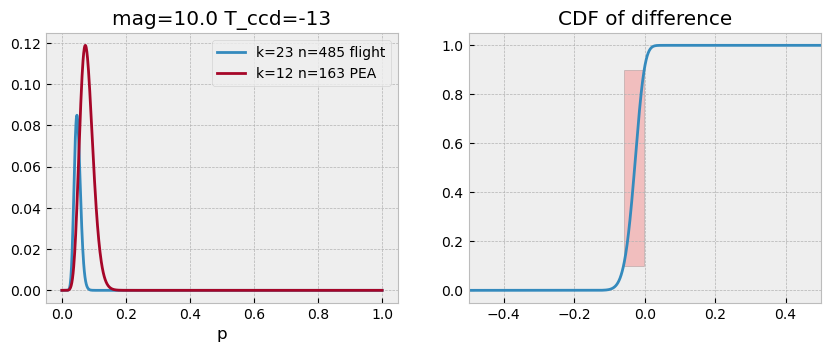

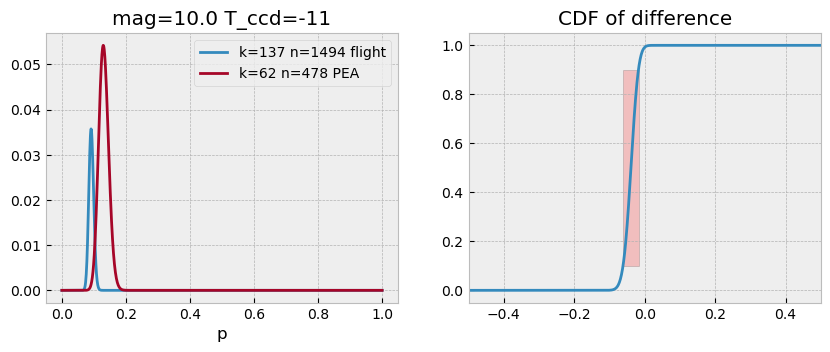

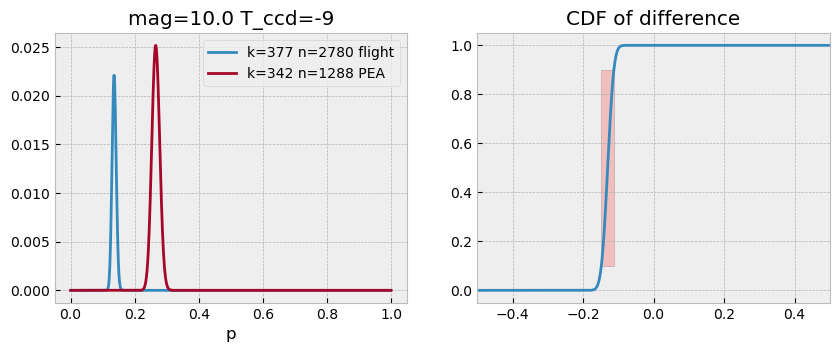

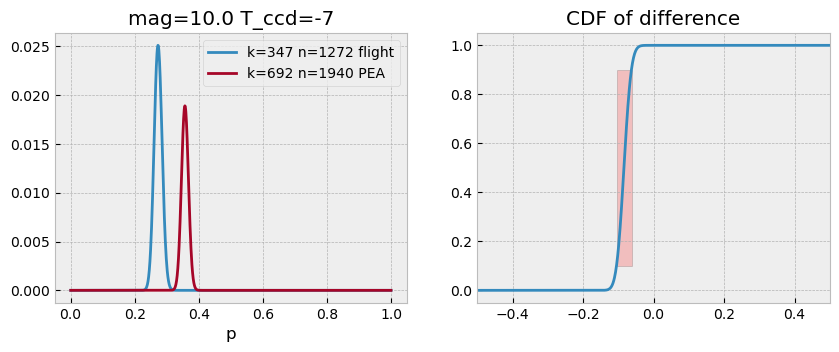

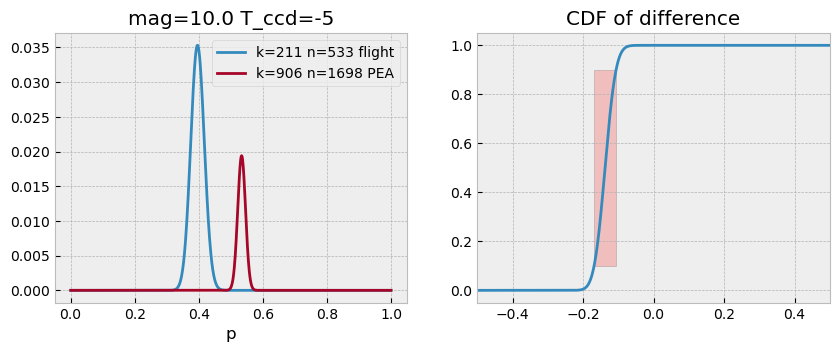

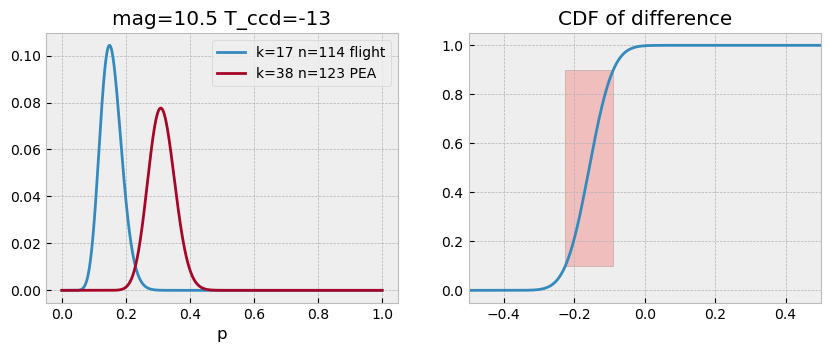

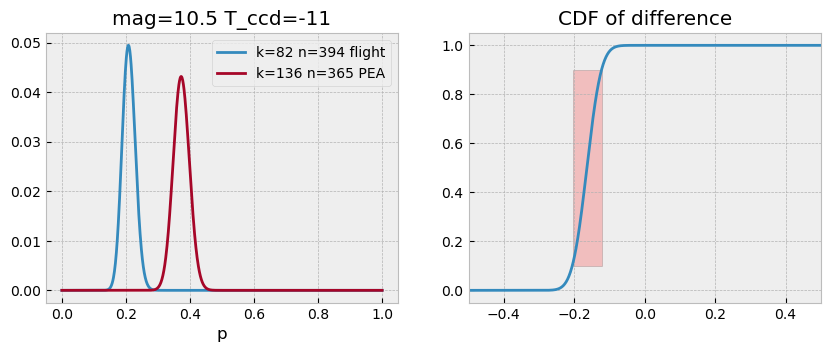

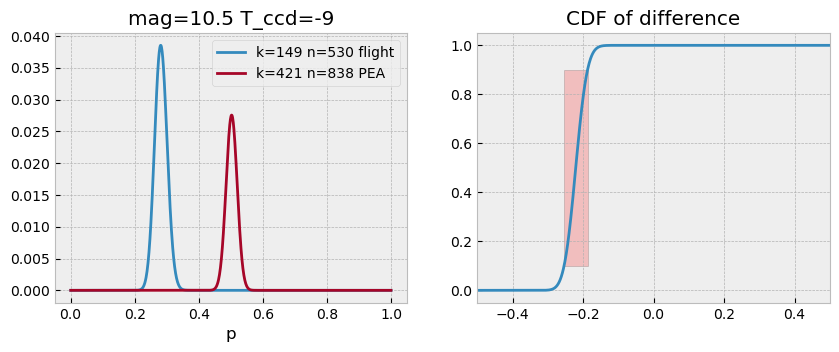

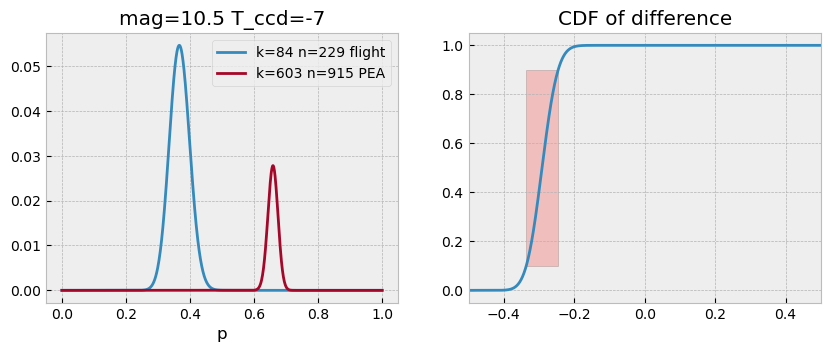

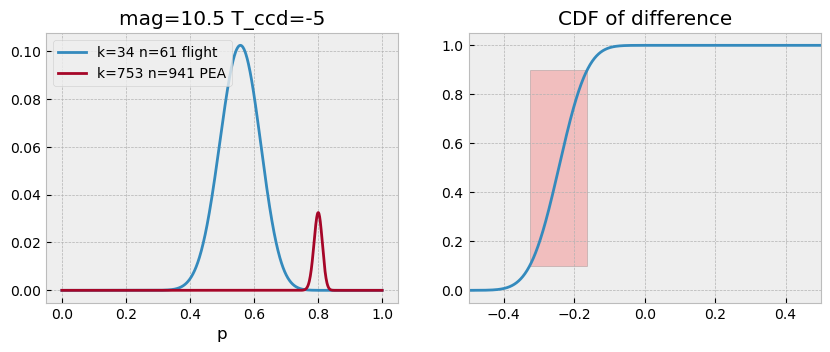

In [66]:
print("Acq Failure Probability Distributions")
ni, nj = n_samp_flt.shape
dp10 = np.zeros(shape=(ni, nj))
dp90 = np.zeros(shape=(ni, nj))
dp = 0.01
p = np.arange(0.0 + dp / 2, 1.0, dp)

for ii in range(3, ni):
    for jj in range(nj):
        if n_samp_flt[ii, jj] < 30 or n_samp_asvt[ii, jj] < 30:
            continue
        k1 = n_fail_flt[ii, jj]
        n1 = n_samp_flt[ii, jj]
        k2 = n_fail_asvt[ii, jj]
        n2 = n_samp_asvt[ii, jj]

        title = f"mag={mag_vals[ii]} T_ccd={t_ccd_vals[jj]}"
        plot_diff_pmf(k1, n1, k2, n2, title, "flight", "PEA")

        pmf1 = binom.pmf(k1, n1, p)
        pmf2 = binom.pmf(k2, n2, p)
        dp, cdf = calc_diff_pmf(p, pmf1, pmf2)

        i10, i90 = np.searchsorted(cdf, [0.1, 0.9])
        dp10[ii, jj] = dp[i10]
        dp90[ii, jj] = dp[i90]
